# 3D BPT Reprojection

### This is a notebook that plots Starforming and AGN models in a reprojected BPT diagram space

In [1]:
import numpy as np
import os

# libraries to plot 3d surfaces
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

#libraries to read Ji & Yan's model grids
import glob
from astropy.io import fits

In [2]:
filename = 'centralflux.fits'
hdul = fits.open(filename)
centralflux_data = hdul[1].data

# see headers of fits file
hdr = hdul[1].header
#print(hdr)

## Standard BPT Diagram

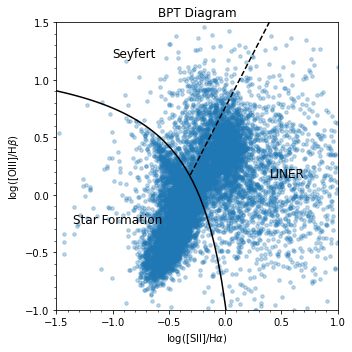

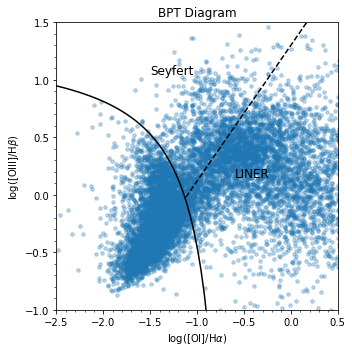

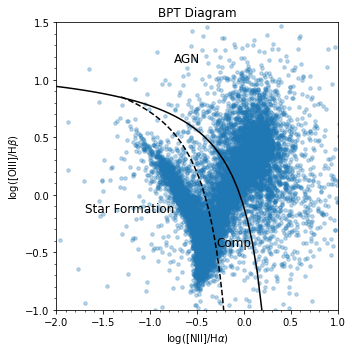

In [3]:
# Kewley (2006) lines
# first create a linspace of points to plot the classification lines
x_SII_sf = np.linspace(-1.5,0.065)
x_SII_sy_liner = np.linspace(-0.31,1.5)

x_NII_sf = np.linspace(-1.31, 0.045)
x_NII_comp = np.linspace(-2.2, 0.35)

x_OI_sf = np.linspace(-2.5, -0.7)
x_OI_sy_liner = np.linspace(-1.12, 0.5)

def starformation_SII(log_SII_Ha):
    """Star formation classification line for log([SII]/Ha)"""
    return 0.72/(log_SII_Ha - 0.32) + 1.30

def seyfert_liner_SII(log_SII_Ha):
    """Seyfert and LINER classification line for log([SII]/Ha)"""
    return 1.89 * log_SII_Ha + 0.76

def seyfert_liner_OI(log_OI_Ha):
    """Seyfert and LINER classification line for log([OI]/Ha)"""
    return 1.18 * log_OI_Ha + 1.30

def starformation_OI(log_OI_Ha):
    """Star formation classification line for log([OI]/Ha)"""
    return 0.73 / (log_OI_Ha + 0.59) + 1.33

def composite_NII(log_NII_Ha):
    """Composite galaxy classification line for log([NII]/Ha)"""
    return 0.61/(log_NII_Ha - 0.47) + 1.19

def starformation_NII(log_NII_Ha):
    """Composite galaxy and LINER classification line for log([NII]/Ha)"""
    return 0.61 / (log_NII_Ha - 0.05) + 1.3

#log([OIII]/H-beta)/([SII]/H-alpha)
plt.figure(figsize = (5,5))
plt.scatter(centralflux_data['log_SII_Ha_cf'], centralflux_data['log_OIII_Hb_cf'],  s = 50, alpha = 0.3, marker ='.', linestyle = 'None')
plt.plot(x_SII_sf, starformation_SII(x_SII_sf), '-k')
plt.plot(x_SII_sy_liner, seyfert_liner_SII(x_SII_sy_liner), '--k')
plt.text(-1,1.2, 'Seyfert', fontsize = 12)
plt.text(-1.35,-0.25, 'Star Formation', fontsize = 12)
plt.text(0.4, 0.15, 'LINER', fontsize = 12)

plt.title('BPT Diagram')
plt.xlabel(r'log([SII]/H${\alpha}$)')
plt.ylabel(r'log([OIII]/H${\beta}$)')
plt.xlim(-1.5,1.0)
plt.ylim(-1.0,1.5)
plt.tight_layout()
plt.minorticks_on()
#plt.savefig('/uufs/chpc.utah.edu/common/home/u6044257/Desktop/BPT_SII_Ha_OIII_Hb.png', overwrite = True)
plt.show()

#log([OIII]/H-beta) & ([OI]/H-alpha)
plt.figure(figsize = (5,5))
plt.scatter(centralflux_data['log_OI_Ha_cf'], centralflux_data['log_OIII_Hb_cf'],  s = 50, alpha = 0.3, marker ='.', linestyle = 'None')
plt.plot(x_OI_sf, starformation_OI(x_OI_sf), '-k')
plt.plot(x_OI_sy_liner, seyfert_liner_OI(x_OI_sy_liner), '--k')
plt.text(-1.5,1.05, 'Seyfert', fontsize = 12)
plt.text(-0.6, 0.15, 'LINER', fontsize = 12)

plt.title('BPT Diagram')
plt.xlabel(r'log([OI]/H${\alpha}$)')
plt.ylabel(r'log([OIII]/H${\beta}$)')
plt.xlim(-2.5,0.5)
plt.ylim(-1.0,1.5)
plt.tight_layout()
plt.minorticks_on()
#plt.savefig('/uufs/chpc.utah.edu/common/home/u6044257/Desktop/BPT_OI_Ha_OIII_Hb.png', overwrite = True)
plt.show()

#log([OIII]/H-beta) & ([NII]/H-alpha)
plt.figure(figsize = (5,5))
plt.scatter(centralflux_data['log_NII_Ha_cf'], centralflux_data['log_OIII_Hb_cf'],  s = 50, alpha = 0.3, marker ='.', linestyle = 'None')
plt.plot(x_NII_sf, starformation_NII(x_NII_sf), '--k')
plt.plot(x_NII_comp, composite_NII(x_NII_comp), '-k')
plt.text(-0.75,1.15, 'AGN', fontsize = 12)
plt.text(-1.7,-0.15, 'Star Formation', fontsize = 12)
plt.text(-0.29, -0.45, 'Comp', fontsize = 12)

plt.title('BPT Diagram')
plt.xlabel(r'log([NII]/H${\alpha}$)')
plt.ylabel(r'log([OIII]/H${\beta}$)')
plt.xlim(-2.0,1.0)
plt.ylim(-1.0,1.5)
plt.tight_layout()
plt.minorticks_on()
#plt.savefig('/uufs/chpc.utah.edu/common/home/u6044257/Desktop/BPT_NII_Ha_OIII_Hb.png', overwrite = True)
plt.show()

## 3D BPT Model

In [4]:
'''
INPUT: modelname: directory + prefix of the model
You can modify the line ratios you want within the function
'''
def read_model(modelname):
    # Load photoionization model grids
    nameList = []
    n_model = len(glob.glob(modelname+'*'))
    for i in range(n_model):
        nameList += [modelname+str(i)+'_line.fits']
        
    # initialize arrays to hold our line ratio calculations
    o3hb_flat = np.array([])
    n2ha_flat = np.array([])
    s2ha_flat = np.array([])
    n2o2_flat = np.array([])
    o3o2_flat = np.array([])

    for name in nameList:
        hdu = fits.open(name)
        # extract emission line fluxes
        o3_flat = hdu[1].data['O__3__5006']
        hb_flat = hdu[1].data['H__1__4861']
        n2_flat = hdu[1].data['N__2__6583']
        ha_flat = hdu[1].data['H__1__6562']
        s2_flat = hdu[1].data['S__2__6716'] + hdu[1].data['S__2__6730']
        o2_flat = hdu[1].data['BLND__3727']

        # line ratios
        o3hb = np.log10(o3_flat/hb_flat)
        n2ha = np.log10(n2_flat/ha_flat)
        s2ha = np.log10(s2_flat/ha_flat)
        o3o2 = np.log10(o3_flat/o2_flat)
        n2o2 = np.log10(n2_flat/o2_flat)
 
        o3hb_flat = np.append(o3hb_flat, o3hb) # appending o3hb line ratio to our initiallized array (o3hb flat)
        n2ha_flat = np.append(n2ha_flat, n2ha)
        s2ha_flat = np.append(s2ha_flat, s2ha)
        o3o2_flat = np.append(o3o2_flat, o3o2)
        n2o2_flat = np.append(n2o2_flat, n2o2)
        
    o3hb_final = o3hb_flat.reshape(n_model, -1)
    n2ha_final = n2ha_flat.reshape(n_model, -1)
    s2ha_final = s2ha_flat.reshape(n_model, -1)
    o3o2_final = o3o2_flat.reshape(n_model, -1)
    n2o2_final = n2o2_flat.reshape(n_model, -1)
    
    return o3hb_final, n2ha_final, s2ha_final, o3o2_final, n2o2_final

## Starforming Model (metallicities ranging from $ -4.0 $ to $-1.5$ in increments of $0.25$)

In [5]:
path_SF = os.getcwd() + '/SF_Models/stb99_c4my_extraplin_'
o3hb_final, n2ha_final, s2ha_final, o3o2_final, n2o2_final = read_model(path_SF)


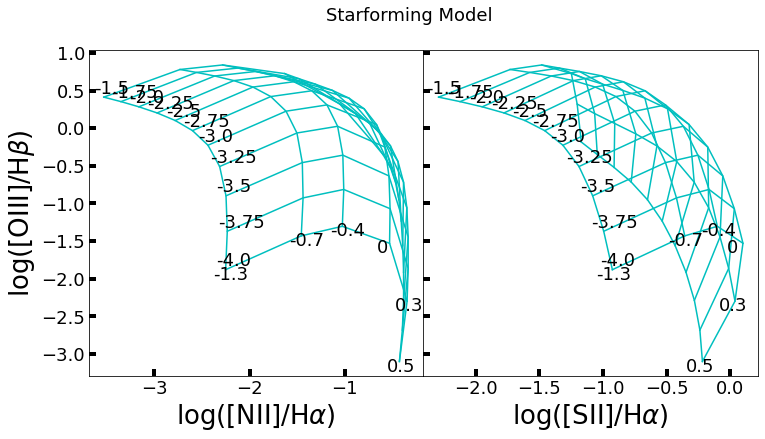

In [6]:
# Plot the model in two BPT diagrams
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
plt.subplots_adjust(wspace=0.)
axes[0].tick_params(labelsize=18, width=4., length=7., direction='in')
axes[1].tick_params(labelsize=18, width=4., length=7., direction='in')
axes[0].set_xlabel('log([NII]/H$\\alpha$)', fontsize=26)
axes[0].set_ylabel('log([OIII]/H$\\beta$)', fontsize=26)
axes[1].set_xlabel('log([SII]/H$\\alpha$)', fontsize=26)
fig.suptitle('Starforming Model ', fontsize= 18)

for i in range(n2ha_final.shape[0]):
    axes[0].plot(n2ha_final[i], o3hb_final[i], color='c', lw=1.5)
    axes[1].plot(s2ha_final[i], o3hb_final[i], color='c', lw=1.5)
for j in range(n2ha_final.shape[1]):
    axes[0].plot(n2ha_final[:,j], o3hb_final[:,j], color='c', lw=1.5)
    axes[1].plot(s2ha_final[:,j], o3hb_final[:,j], color='c', lw=1.5)
    
q_text = np.linspace(-4., -1.5, 11, dtype='str')
z_text = ['-1.3', '-0.7', '-0.4', '0', '0.3', '0.5']
for k in range(11):
    axes[0].text((n2ha_final[0][k])-0.1, (o3hb_final[0][k])+0.05, 
                 str(q_text[k]),
                 fontsize=18)
    axes[1].text((s2ha_final[0][k])-0.1, (o3hb_final[0][k])+0.05, 
                 str(q_text[k]),
                 fontsize=18)
for l in range(6):
    axes[0].text((n2ha_final[:,0][l])-0.13, (o3hb_final[:,0][l])-0.13, 
                 str(z_text[l]),
                 fontsize=18)
    axes[1].text((s2ha_final[:,0][l])-0.13, (o3hb_final[:,0][l])-0.13, 
                 str(z_text[l]),
                 fontsize=18)


## AGN model (power law SED with a slope of -1.4)

In [7]:
path_1d4 = os.getcwd() + '/AGNm1d4_models/bplm1d4_hden2_gro_'

o3hb_final_1d4, n2ha_final_1d4, s2ha_final_1d4, o3o2_final_1d4, n2o2_1d4_final = read_model(path_1d4)


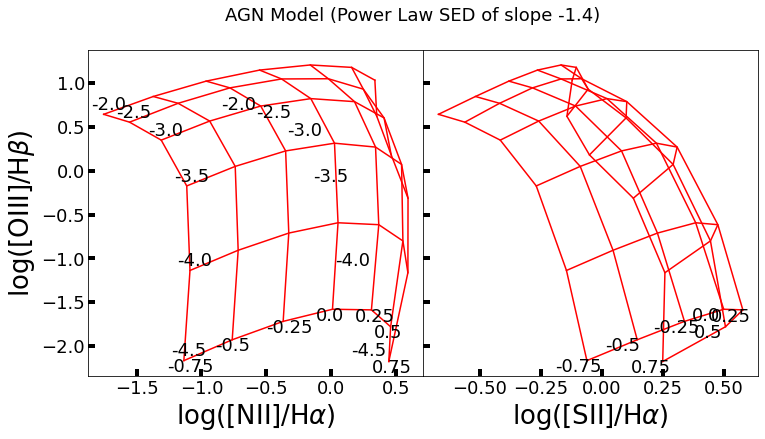

In [8]:
# Plot the model in two BPT diagrams
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
plt.subplots_adjust(wspace=0.)
axes[0].tick_params(labelsize=18, width=4., length=7., direction='in')
axes[1].tick_params(labelsize=18, width=4., length=7., direction='in')
axes[0].set_xlabel('log([NII]/H$\\alpha$)', fontsize=26)
axes[0].set_ylabel('log([OIII]/H$\\beta$)', fontsize=26)
axes[1].set_xlabel('log([SII]/H$\\alpha$)', fontsize=26)
fig.suptitle('AGN Model (Power Law SED of slope -1.4)', fontsize= 18)


for i in range(n2ha_final_1d4.shape[0]):
    axes[0].plot(n2ha_final_1d4[i], o3hb_final_1d4[i], color='r', lw=1.5)
    axes[1].plot(s2ha_final_1d4[i], o3hb_final_1d4[i], color='r', lw=1.5)
for j in range(n2ha_final_1d4.shape[1]):
    axes[0].plot(n2ha_final_1d4[:,j], o3hb_final_1d4[:,j], color='r', lw=1.5)
    axes[1].plot(s2ha_final_1d4[:,j], o3hb_final_1d4[:,j], color='r', lw=1.5)
    
q_text_1d4 = np.linspace(-4.5, -2., 6, dtype='str')
z_text_1d4 = np.linspace(-.75, .75, 7, dtype='str')
for k in range(6):
    axes[0].text((n2ha_final_1d4[0][k])-0.1, (o3hb_final_1d4[0][k])+0.05, 
                 str(q_text_1d4[k]),
                 fontsize=18)
    axes[1].text((s2ha_final[0][k])-0.1, (o3hb_final_1d4[0][k])+0.05, 
                 str(q_text_1d4[k]),
                 fontsize=18)
for l in range(7):
    axes[0].text((n2ha_final_1d4[:,0][l])-0.13, (o3hb_final_1d4[:,0][l])-0.13, 
                 str(z_text_1d4[l]),
                 fontsize=18)
    axes[1].text((s2ha_final_1d4[:,0][l])-0.13, (o3hb_final_1d4[:,0][l])-0.13, 
                 str(z_text_1d4[l]),
                 fontsize=18)

## AGN model (power law SED with a slope of -1.7)

In [9]:
path_1d7 = os.getcwd() + '/AGNm1d7_models/bplm1d7_fel_segro_'

o3hb_final_1d7, n2ha_final_1d7, s2ha_final_1d7, o3o2_final_1d7, n2o2_final_1d7 = read_model(path_1d7)


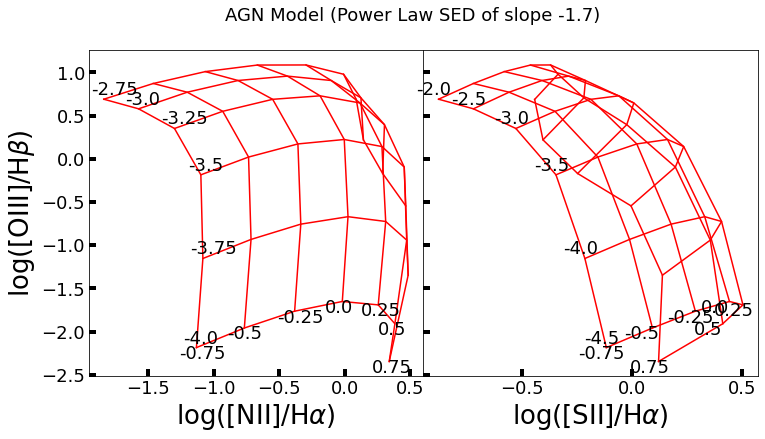

In [10]:
# Plot the model in two BPT diagrams
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
plt.subplots_adjust(wspace=0.)
axes[0].tick_params(labelsize=18, width=4., length=7., direction='in')
axes[1].tick_params(labelsize=18, width=4., length=7., direction='in')
axes[0].set_xlabel('log([NII]/H$\\alpha$)', fontsize=26)
axes[0].set_ylabel('log([OIII]/H$\\beta$)', fontsize=26)
axes[1].set_xlabel('log([SII]/H$\\alpha$)', fontsize=26)
fig.suptitle('AGN Model (Power Law SED of slope -1.7)', fontsize= 18)

for i in range(n2ha_final_1d7.shape[0]):
    axes[0].plot(n2ha_final_1d7[i], o3hb_final_1d7[i], color='r', lw=1.5)
    axes[1].plot(s2ha_final_1d7[i], o3hb_final_1d7[i], color='r', lw=1.5)
for j in range(n2ha_final_1d7.shape[1]):
    axes[0].plot(n2ha_final_1d7[:,j], o3hb_final_1d7[:,j], color='r', lw=1.5)
    axes[1].plot(s2ha_final_1d7[:,j], o3hb_final_1d7[:,j], color='r', lw=1.5)
    
q_text_1d7 = np.linspace(-4.5, -2., 6, dtype='str')
z_text_1d7 = np.linspace(-.75, .75, 7, dtype='str')

for k in range(6):
    axes[0].text((n2ha_final_1d7[0][k])-0.1, (o3hb_final_1d7[0][k])+0.05, 
                 str(q_text[k]),
                 fontsize=18)
    axes[1].text((s2ha_final_1d7[0][k])-0.1, (o3hb_final_1d7[0][k])+0.05, 
                 str(q_text_1d7[k]),
                 fontsize=18)
for l in range(7):
    axes[0].text((n2ha_final_1d7[:,0][l])-0.13, (o3hb_final_1d7[:,0][l])-0.13, 
                 str(z_text_1d7[l]),
                 fontsize=18)
    axes[1].text((s2ha_final_1d7[:,0][l])-0.13, (o3hb_final_1d7[:,0][l])-0.13, 
                 str(z_text_1d7[l]),
                 fontsize=18)

## BPT diagram of central flux measurements of our  galaxy sample with the starforming model overlaid

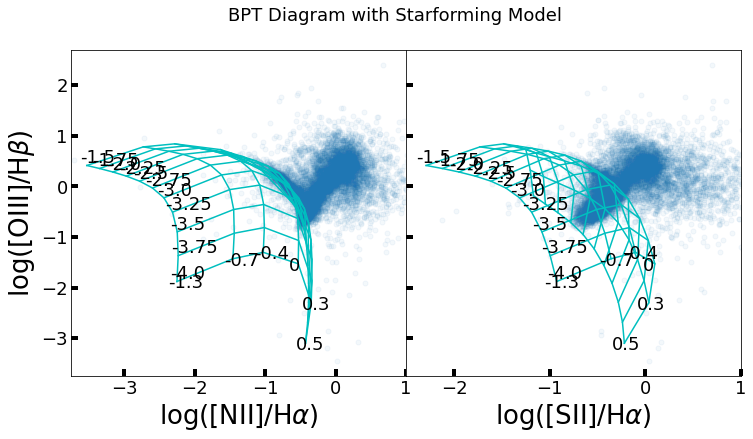

In [11]:
# STARFORMING MODEL
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
plt.subplots_adjust(wspace=0.)
axes[0].tick_params(labelsize=18, width=4., length=7., direction='in')
axes[1].tick_params(labelsize=18, width=4., length=7., direction='in')
axes[0].set_xlabel('log([NII]/H$\\alpha$)', fontsize=26)
axes[0].set_ylabel('log([OIII]/H$\\beta$)', fontsize=26)
axes[1].set_xlabel('log([SII]/H$\\alpha$)', fontsize=26)
fig.suptitle('BPT Diagram with Starforming Model', fontsize= 18)

# CENTRALFLUX DATA

axes[0].scatter(centralflux_data['log_NII_Ha_cf'], centralflux_data['log_OIII_Hb_cf'], alpha = 0.05,s = 25)
axes[0].set_xlim(-3.75,1.0)
axes[1].scatter(centralflux_data['log_SII_Ha_cf'], centralflux_data['log_OIII_Hb_cf'], alpha = 0.05,s = 25)
axes[1].set_xlim(-2.5,1.0)

for i in range(n2ha_final.shape[0]):
    axes[0].plot(n2ha_final[i], o3hb_final[i], color='c', lw=1.5)
    axes[1].plot(s2ha_final[i], o3hb_final[i], color='c', lw=1.5)
for j in range(n2ha_final.shape[1]):
    axes[0].plot(n2ha_final[:,j], o3hb_final[:,j], color='c', lw=1.5)
    axes[1].plot(s2ha_final[:,j], o3hb_final[:,j], color='c', lw=1.5)
    
q_text = np.linspace(-4., -1.5, 11, dtype='str')
z_text = ['-1.3', '-0.7', '-0.4', '0', '0.3', '0.5']
for k in range(11):
    axes[0].text((n2ha_final[0][k])-0.1, (o3hb_final[0][k])+0.05, 
                 str(q_text[k]),
                 fontsize=18)
    axes[1].text((s2ha_final[0][k])-0.1, (o3hb_final[0][k])+0.05, 
                 str(q_text[k]),
                 fontsize=18)
for l in range(6):
    axes[0].text((n2ha_final[:,0][l])-0.13, (o3hb_final[:,0][l])-0.13, 
                 str(z_text[l]),
                 fontsize=18)
    axes[1].text((s2ha_final[:,0][l])-0.13, (o3hb_final[:,0][l])-0.13, 
                 str(z_text[l]),
                 fontsize=18)


## BPT diagram of central flux measurements of our  galaxy sample with the AGN  model (-1.4 power law slope) overlaid

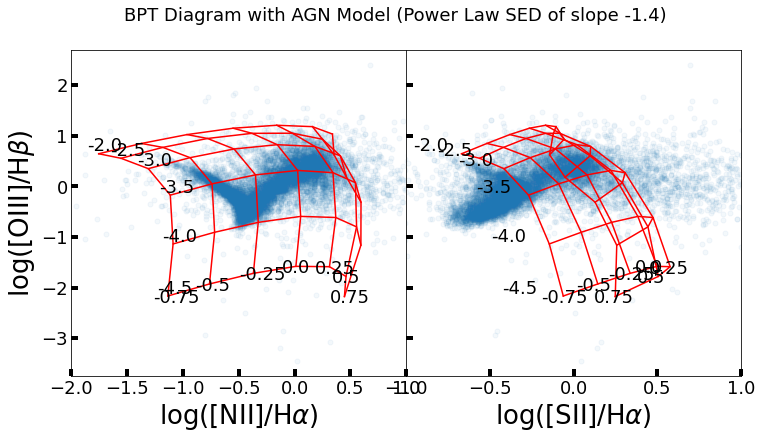

In [12]:
# -1.4 POWER LAW SLOPE AGN MODEL
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
plt.subplots_adjust(wspace=0.)
axes[0].tick_params(labelsize=18, width=4., length=7., direction='in')
axes[1].tick_params(labelsize=18, width=4., length=7., direction='in')
axes[0].set_xlabel('log([NII]/H$\\alpha$)', fontsize=26)
axes[0].set_ylabel('log([OIII]/H$\\beta$)', fontsize=26)
axes[1].set_xlabel('log([SII]/H$\\alpha$)', fontsize=26)
fig.suptitle('BPT Diagram with AGN Model (Power Law SED of slope -1.4)', fontsize= 18)

# CENTRALFLUX DATA
axes[0].scatter(centralflux_data['log_NII_Ha_cf'], centralflux_data['log_OIII_Hb_cf'], alpha = 0.05,s = 25)
axes[0].set_xlim(-2.0,1.0)
axes[1].scatter(centralflux_data['log_SII_Ha_cf'], centralflux_data['log_OIII_Hb_cf'], alpha = 0.05,s = 25)
axes[1].set_xlim(-1.0,1.0)

for i in range(n2ha_final_1d4.shape[0]):
    axes[0].plot(n2ha_final_1d4[i], o3hb_final_1d4[i], color='r', lw=1.5)
    axes[1].plot(s2ha_final_1d4[i], o3hb_final_1d4[i], color='r', lw=1.5)
for j in range(n2ha_final_1d4.shape[1]):
    axes[0].plot(n2ha_final_1d4[:,j], o3hb_final_1d4[:,j], color='r', lw=1.5)
    axes[1].plot(s2ha_final_1d4[:,j], o3hb_final_1d4[:,j], color='r', lw=1.5)
    
q_text_1d4 = np.linspace(-4.5, -2., 6, dtype='str')
z_text_1d4 = np.linspace(-.75, .75, 7, dtype='str')

for k in range(6):
    axes[0].text((n2ha_final_1d4[0][k])-0.1, (o3hb_final_1d4[0][k])+0.05, 
                 str(q_text_1d4[k]),
                 fontsize=18)
    axes[1].text((s2ha_final[0][k])+0.5, (o3hb_final_1d4[0][k])+0.05, 
                 str(q_text_1d4[k]),
                 fontsize=18)
for l in range(7):
    axes[0].text((n2ha_final_1d4[:,0][l])-0.13, (o3hb_final_1d4[:,0][l])-0.13, 
                 str(z_text_1d4[l]),
                 fontsize=18)
    axes[1].text((s2ha_final_1d4[:,0][l])-0.13, (o3hb_final_1d4[:,0][l])-0.13, 
                 str(z_text_1d4[l]),
                 fontsize=18)


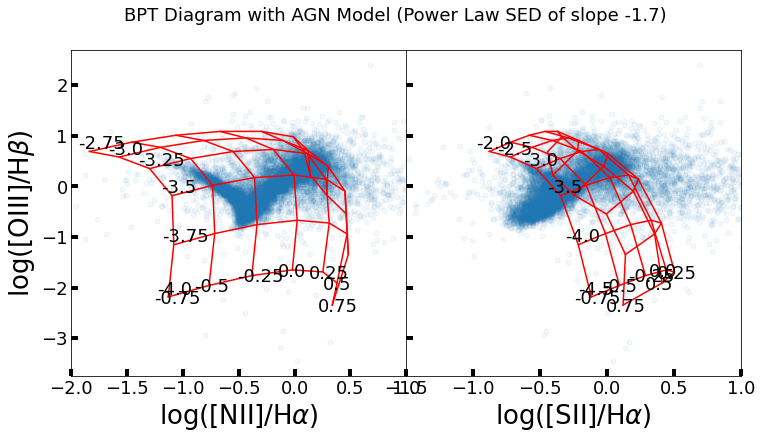

In [13]:
# -1.7 POWER LAW SLOPE AGN MODEL
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
plt.subplots_adjust(wspace=0.)
axes[0].tick_params(labelsize=18, width=4., length=7., direction='in')
axes[1].tick_params(labelsize=18, width=4., length=7., direction='in')
axes[0].set_xlabel('log([NII]/H$\\alpha$)', fontsize=26)
axes[0].set_ylabel('log([OIII]/H$\\beta$)', fontsize=26)
axes[1].set_xlabel('log([SII]/H$\\alpha$)', fontsize=26)
fig.suptitle('BPT Diagram with AGN Model (Power Law SED of slope -1.7)', fontsize= 18)

# CENTRALFLUX DATA
axes[0].scatter(centralflux_data['log_NII_Ha_cf'], centralflux_data['log_OIII_Hb_cf'], alpha = 0.05,s = 25)
axes[0].set_xlim(-2.0,1.0)
axes[1].scatter(centralflux_data['log_SII_Ha_cf'], centralflux_data['log_OIII_Hb_cf'], alpha = 0.05,s = 25)
axes[1].set_xlim(-1.5,1.0)

for i in range(n2ha_final_1d7.shape[0]):
    axes[0].plot(n2ha_final_1d7[i], o3hb_final_1d7[i], color='r', lw=1.5)
    axes[1].plot(s2ha_final_1d7[i], o3hb_final_1d7[i], color='r', lw=1.5)
for j in range(n2ha_final_1d7.shape[1]):
    axes[0].plot(n2ha_final_1d7[:,j], o3hb_final_1d7[:,j], color='r', lw=1.5)
    axes[1].plot(s2ha_final_1d7[:,j], o3hb_final_1d7[:,j], color='r', lw=1.5)
    
q_text_1d7 = np.linspace(-4.5, -2., 6, dtype='str')
z_text_1d7 = np.linspace(-.75, .75, 7, dtype='str')

for k in range(6):
    axes[0].text((n2ha_final_1d7[0][k])-0.1, (o3hb_final_1d7[0][k])+0.05, 
                 str(q_text[k]),
                 fontsize=18)
    axes[1].text((s2ha_final_1d7[0][k])-0.1, (o3hb_final_1d7[0][k])+0.05, 
                 str(q_text_1d7[k]),
                 fontsize=18)
for l in range(7):
    axes[0].text((n2ha_final_1d7[:,0][l])-0.13, (o3hb_final_1d7[:,0][l])-0.13, 
                 str(z_text_1d7[l]),
                 fontsize=18)
    axes[1].text((s2ha_final_1d7[:,0][l])-0.13, (o3hb_final_1d7[:,0][l])-0.13, 
                 str(z_text_1d7[l]),
                 fontsize=18)

# P1 and P2 Plane

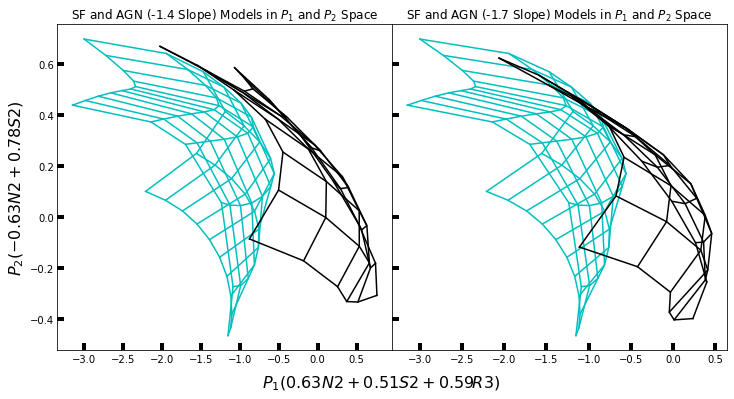

In [14]:
# P1 and P2 Plane
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
plt.subplots_adjust(wspace=0.)
axes[0].tick_params(labelsize=10, width=4., length=7., direction='in')
axes[1].tick_params(labelsize=10, width=4., length=7., direction='in')

fig.text(0.5, 0.04, '$P_{1}(0.63N2 + 0.51S2 + 0.59R3)$', ha='center', fontsize = 16)
axes[0].set_ylabel('$P_{2}(-0.63N2 + 0.78 S2)$', fontsize=16)
axes[0].set_title('SF and AGN (-1.4 Slope) Models in $P_{1}$ and $P_{2}$ Space', fontsize= 12)
axes[1].set_title('SF and AGN (-1.7 Slope) Models in $P_{1}$ and $P_{2}$ Space', fontsize= 12)

# Starforming Model
for i in range(n2ha_final.shape[0]): #ionization
    axes[0].plot(0.63*n2ha_final[i] + 0.51*s2ha_final[i] + 0.59*o3hb_final[i],-0.63*n2ha_final[i] + 0.78*s2ha_final[i], color='c', lw=1.5)
    axes[1].plot(0.63*n2ha_final[i] + 0.51*s2ha_final[i] + 0.59*o3hb_final[i],-0.63*n2ha_final[i] + 0.78*s2ha_final[i], color='c', lw=1.5)

for j in range(n2ha_final.shape[1]): #metallicity
    axes[0].plot(0.63*n2ha_final[:,j] + 0.51*s2ha_final[:,j] + 0.59*o3hb_final[:,j], -0.63*n2ha_final[:,j] + 0.78*s2ha_final[:,j], color='c', lw=1.5)
    axes[1].plot(0.63*n2ha_final[:,j] + 0.51*s2ha_final[:,j] + 0.59*o3hb_final[:,j], -0.63*n2ha_final[:,j] + 0.78*s2ha_final[:,j], color='c', lw=1.5)

# AGN (-1.4 Model)
for m in range(n2ha_final_1d4.shape[0]):
    axes[0].plot(0.63*n2ha_final_1d4[m] + 0.51*s2ha_final_1d4[m] + 0.59*o3hb_final_1d4[m],-0.63*n2ha_final_1d4[m] + 0.78*s2ha_final_1d4[m], color='k', lw=1.5)
    
for n in range(n2ha_final_1d4.shape[1]):
    axes[0].plot(0.63*n2ha_final_1d4[:,n] + 0.51*s2ha_final_1d4[:,n] + 0.59*o3hb_final_1d4[:,n], -0.63*n2ha_final_1d4[:,n] + 0.78*s2ha_final_1d4[:,n], color='k', lw=1.5)

# AGN (-1.7 Model)
for k in range(n2ha_final_1d7.shape[0]):
    axes[1].plot(0.63*n2ha_final_1d7[k] + 0.51*s2ha_final_1d7[k] + 0.59*o3hb_final_1d7[k],-0.63*n2ha_final_1d7[k] + 0.78*s2ha_final_1d7[k], color='k', lw=1.5)

for l in range(n2ha_final_1d7.shape[1]):
    axes[1].plot(0.63*n2ha_final_1d7[:,l] + 0.51*s2ha_final_1d7[:,l] + 0.59*o3hb_final_1d7[:,l], -0.63*n2ha_final_1d7[:,l] + 0.78*s2ha_final_1d7[:,l], color='k', lw=1.5)
    

    

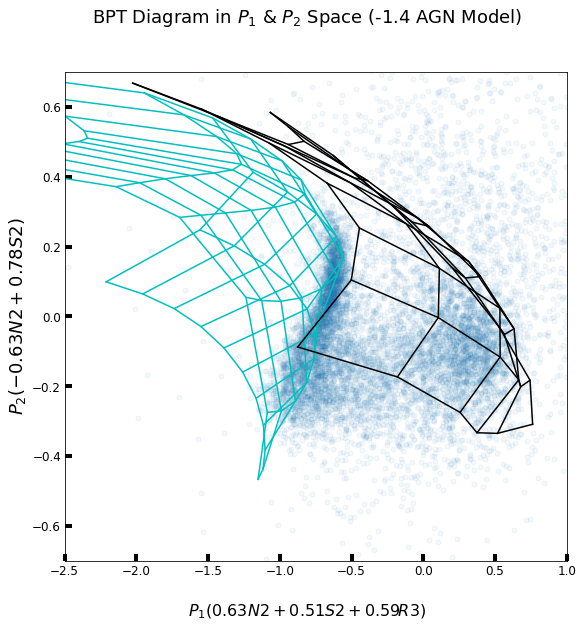

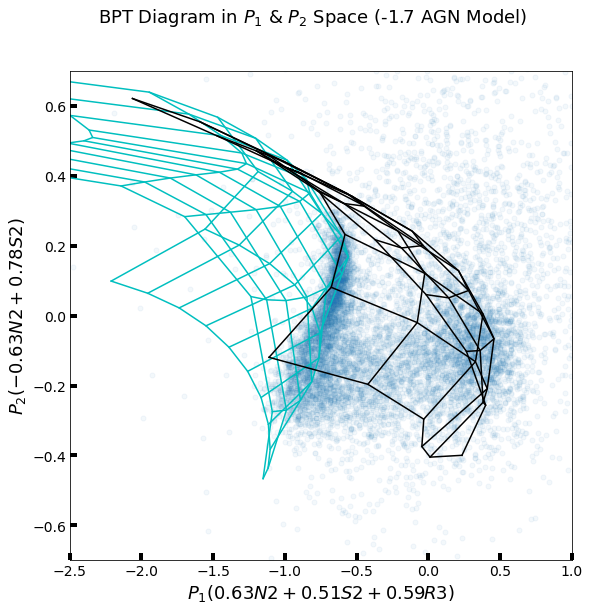

In [15]:
# BPT diagram in P1 and P2 Plane with -1.4 AGN Model
fig, axes = plt.subplots(figsize=(9, 9))
plt.subplots_adjust(wspace=0.)

axes.tick_params(labelsize=12, width=4., length=7., direction='in')
fig.text(0.5, 0.04, '$P_{1}(0.63N2 + 0.51S2 + 0.59R3)$', ha='center', fontsize = 16)
axes.set_ylabel('$P_{2}(-0.63N2 + 0.78 S2)$', fontsize=18)
fig.suptitle('BPT Diagram in $P_{1}$ & $P_{2}$ Space (-1.4 AGN Model)', fontsize=18 )

# Starforming Model
for i in range(n2ha_final.shape[0]): #ionization
    axes.plot(0.63*n2ha_final[i] + 0.51*s2ha_final[i] + 0.59*o3hb_final[i],-0.63*n2ha_final[i] + 0.78*s2ha_final[i], color='c', lw=1.5)
    
for j in range(n2ha_final.shape[1]): #metallicity
    axes.plot(0.63*n2ha_final[:,j] + 0.51*s2ha_final[:,j] + 0.59*o3hb_final[:,j], -0.63*n2ha_final[:,j] + 0.78*s2ha_final[:,j], color='c', lw=1.5)

# AGN (-1.4 Model)
for m in range(n2ha_final_1d4.shape[0]):
    axes.plot(0.63*n2ha_final_1d4[m] + 0.51*s2ha_final_1d4[m] + 0.59*o3hb_final_1d4[m],-0.63*n2ha_final_1d4[m] + 0.78*s2ha_final_1d4[m], color='k', lw=1.5)

for n in range(n2ha_final_1d4.shape[1]):
    axes.plot(0.63*n2ha_final_1d4[:,n] + 0.51*s2ha_final_1d4[:,n] + 0.59*o3hb_final_1d4[:,n], -0.63*n2ha_final_1d4[:,n] + 0.78*s2ha_final_1d4[:,n], color='k', lw=1.5)

# CENTRALFLUX DATA
axes.scatter(0.63*centralflux_data['log_NII_Ha_cf']+ 0.51*centralflux_data['log_SII_Ha_cf'] + 0.59*centralflux_data['log_OIII_Hb_cf'], -0.63*centralflux_data['log_NII_Ha_cf'] + 0.78*centralflux_data['log_SII_Ha_cf'], alpha = 0.05, s = 25)
axes.set_xlim(-2.5,1.0)
axes.set_ylim(-0.7,0.7)


# BPT diagram in P1 and P2 Plane with -1.7 AGN Model
fig, axes = plt.subplots(figsize=(9, 9))
plt.subplots_adjust(wspace=0.)
axes.tick_params(labelsize=14, width=4., length=7., direction='in')

axes.set_xlabel('$P_{1}(0.63N2 + 0.51S2 + 0.59R3)$', fontsize=18)
axes.set_ylabel('$P_{2}(-0.63N2 + 0.78 S2)$', fontsize=18)
fig.suptitle('BPT Diagram in $P_{1}$ & $P_{2}$ Space (-1.7 AGN Model)', fontsize=18 )

# Starforming Model
for i in range(n2ha_final.shape[0]): #ionization
    axes.plot(0.63*n2ha_final[i] + 0.51*s2ha_final[i] + 0.59*o3hb_final[i], -0.63*n2ha_final[i] + 0.78*s2ha_final[i], color='c', lw=1.5)
    
for j in range(n2ha_final.shape[1]): #metallicity
    axes.plot(0.63*n2ha_final[:,j] + 0.51*s2ha_final[:,j] + 0.59*o3hb_final[:,j], -0.63*n2ha_final[:,j] + 0.78*s2ha_final[:,j], color='c', lw=1.5)

# AGN (-1.7 Model)
for k in range(n2ha_final_1d7.shape[0]):
    axes.plot(0.63*n2ha_final_1d7[k] + 0.51*s2ha_final_1d7[k] + 0.59*o3hb_final_1d7[k], -0.63*n2ha_final_1d7[k] + 0.78*s2ha_final_1d7[k], color='k', lw=1.5)

for l in range(n2ha_final_1d7.shape[1]):
    axes.plot(0.63*n2ha_final_1d7[:,l] + 0.51*s2ha_final_1d7[:,l] + 0.59*o3hb_final_1d7[:,l], -0.63*n2ha_final_1d7[:,l] + 0.78*s2ha_final_1d7[:,l], color='k', lw=1.5)

# CENTRALFLUX DATA
axes.scatter(0.63*centralflux_data['log_NII_Ha_cf']+ 0.51*centralflux_data['log_SII_Ha_cf'] + 0.59*centralflux_data['log_OIII_Hb_cf'], -0.63*centralflux_data['log_NII_Ha_cf'] + 0.78*centralflux_data['log_SII_Ha_cf'], alpha = 0.05, s = 25)
axes.set_xlim(-2.5,1.0)
axes.set_ylim(-0.7,0.7)

plt.show()

## $P_{1}$ and $P_{3}$ Space

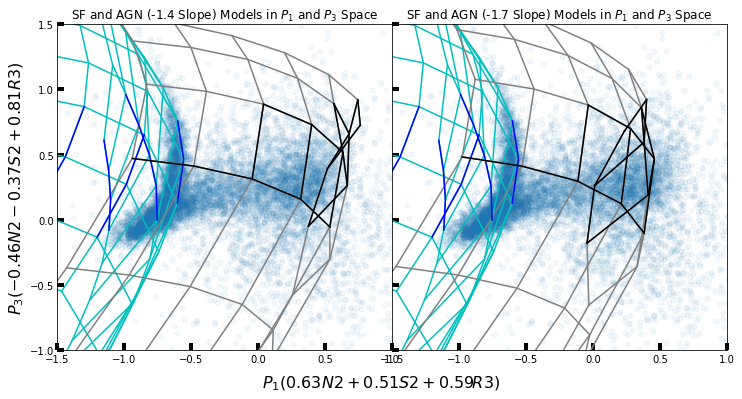

In [80]:
# P1 and P3 Plane
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
plt.subplots_adjust(wspace=0.)
axes[0].tick_params(labelsize=10, width=4., length=7., direction='in')
axes[1].tick_params(labelsize=10, width=4., length=7., direction='in')

fig.text(0.5, 0.04, '$P_{1}(0.63N2 + 0.51S2 + 0.59R3)$', ha='center', fontsize = 16)
axes[0].set_ylabel('$P_{3}(-0.46N2 - 0.37S2 + 0.81R3)$', fontsize=16)
axes[0].set_title('SF and AGN (-1.4 Slope) Models in $P_{1}$ and $P_{3}$ Space', fontsize= 12)
axes[1].set_title('SF and AGN (-1.7 Slope) Models in $P_{1}$ and $P_{3}$ Space', fontsize= 12)

# Starforming Model
for i in range(n2ha_final.shape[0]): #ionization
    axes[0].plot(0.63*n2ha_final[i] + 0.51*s2ha_final[i] + 0.59*o3hb_final[i], -0.46*n2ha_final[i] - 0.37*s2ha_final[i] + 0.81*o3hb_final[i], color='c', lw=1.5)
    axes[1].plot(0.63*n2ha_final[i] + 0.51*s2ha_final[i] + 0.59*o3hb_final[i], -0.46*n2ha_final[i] - 0.37*s2ha_final[i] + 0.81*o3hb_final[i], color='c', lw=1.5)

for j in range(n2ha_final.shape[1]): #metallicity
    axes[0].plot(0.63*n2ha_final[:,j] + 0.51*s2ha_final[:,j] + 0.59*o3hb_final[:,j], -0.46*n2ha_final[:,j] - 0.37*s2ha_final[:,j] + 0.81*o3hb_final[:,j], color='c', lw=1.5)
    axes[1].plot(0.63*n2ha_final[:,j] + 0.51*s2ha_final[:,j] + 0.59*o3hb_final[:,j], -0.46*n2ha_final[:,j] - 0.37*s2ha_final[:,j] + 0.81*o3hb_final[:,j], color='c', lw=1.5)

# AGN (-1.4 Model)
for i in range(n2ha_final_1d4.shape[0]):
    axes[0].plot(0.63*n2ha_final_1d4[i] + 0.51*s2ha_final_1d4[i] + 0.59*o3hb_final_1d4[i], -0.46*n2ha_final_1d4[i] - 0.37*s2ha_final_1d4[i] + 0.81*o3hb_final_1d4[i], color='gray', lw=1.5)
    
for j in range(n2ha_final_1d4.shape[1]):
    axes[0].plot(0.63*n2ha_final_1d4[:,j] + 0.51*s2ha_final_1d4[:,j] + 0.59*o3hb_final_1d4[:,j], -0.46*n2ha_final_1d4[:,j] - 0.37*s2ha_final_1d4[:,j] + 0.81*o3hb_final_1d4[:,j], color='gray', lw=1.5)

# AGN (-1.7 Model)
for i in range(n2ha_final_1d7.shape[0]):
    axes[1].plot(0.63*n2ha_final_1d7[i] + 0.51*s2ha_final_1d7[i] + 0.59*o3hb_final_1d7[i], -0.46*n2ha_final_1d7[i] - 0.37*s2ha_final_1d7[i] + 0.81*o3hb_final_1d7[i],  color='gray', lw=1.5)

for j in range(n2ha_final_1d7.shape[1]):
    axes[1].plot(0.63*n2ha_final_1d7[:,j] + 0.51*s2ha_final_1d7[:,j] + 0.59*o3hb_final_1d7[:,j], -0.46*n2ha_final_1d7[:,j] - 0.37*s2ha_final_1d7[:,j] + 0.81*o3hb_final_1d7[:,j], color='gray', lw=1.5)
    
# Overlay parts of the model that need to be cut
for i in range(n2ha_final.shape[0]):
    new_keep_SF = keep_SF[i]
    new_P1_SF = P1_SF[i]
    new_P3_SF = P3_SF[i]

    axes[0].plot(new_P1_SF[new_keep_SF], new_P3_SF[new_keep_SF], color='b', lw=1.5)
    axes[1].plot(new_P1_SF[new_keep_SF], new_P3_SF[new_keep_SF], color='b', lw=1.5)

for j in range(n2ha_final.shape[1]):
    new_keep_SF = keep_SF[:, b]
    new_P1_SF = P1_SF[:, b]
    new_P3_SF = P3_SF[:, b]

    axes[0].plot(new_P1_SF[new_keep_SF], new_P3_SF[new_keep_SF], color='b', lw=1.5)
    axes[1].plot(new_P1_SF[new_keep_SF], new_P3_SF[new_keep_SF], color='b', lw=1.5)
    
# -1.4 AGN MODEL
for i in range(n2ha_final_1d4.shape[0]):
    new_keep_AGN1d4 = keep_AGN1d4[i]
    new_P1_AGN1d4 = P1_AGN1d4[i]
    new_P3_AGN1d4 = P3_AGN1d4[i]

    axes[0].plot(new_P1_AGN1d4[new_keep_AGN1d4], new_P3_AGN1d4[new_keep_AGN1d4], color='k', lw=1.5)

for j in range(n2ha_final_1d4.shape[1]):
    new_keep_AGN1d4 = keep_AGN1d4[:, j]
    new_P1_AGN1d4 = P1_AGN1d4[:, j]
    new_P3_AGN1d4 = P3_AGN1d4[:, j]

    axes[0].plot(new_P1_AGN1d4[new_keep_AGN1d4], new_P3_AGN1d4[new_keep_AGN1d4], color='k', lw=1.5)

# -1.7 AGN MODEL
for i in range(n2ha_final_1d7.shape[0]):
    new_keep_AGN1d7 = keep_AGN1d7[i]
    new_P1_AGN1d7 = P1_AGN1d7[i]
    new_P3_AGN1d7 = P3_AGN1d7[i]

    axes[1].plot(new_P1_AGN1d7[new_keep_AGN1d7], new_P3_AGN1d7[new_keep_AGN1d7], color='k', lw=1.5)

for j in range(n2ha_final_1d7.shape[1]):
    new_keep_AGN1d7 = keep_AGN1d7[:, j]
    new_P1_AGN1d7 = P1_AGN1d7[:, j]
    new_P3_AGN1d7 = P3_AGN1d7[:, j]

    axes[1].plot(new_P1_AGN1d7[new_keep_AGN1d7], new_P3_AGN1d7[new_keep_AGN1d7], color='k', lw=1.5)

# CENTRALFLUX DATA
axes[0].scatter(0.63*centralflux_data['log_NII_Ha_cf'] + 0.51*centralflux_data['log_SII_Ha_cf'] + 0.59*centralflux_data['log_OIII_Hb_cf'], -0.46*centralflux_data['log_NII_Ha_cf'] - 0.37*centralflux_data['log_SII_Ha_cf'] + 0.81*centralflux_data['log_OIII_Hb_cf'], alpha = 0.05, s = 25)
axes[1].scatter(0.63*centralflux_data['log_NII_Ha_cf'] + 0.51*centralflux_data['log_SII_Ha_cf'] + 0.59*centralflux_data['log_OIII_Hb_cf'], -0.46*centralflux_data['log_NII_Ha_cf'] - 0.37*centralflux_data['log_SII_Ha_cf'] + 0.81*centralflux_data['log_OIII_Hb_cf'], alpha = 0.05, s = 25)

axes[0].set_xlim(-1.5, 1.0)
axes[0].set_ylim(-1.0,1.5)
axes[1].set_xlim(-1.5, 1.0)
axes[1].set_ylim(-1.0,1.5)
    
plt.show()

# Now we want to cut our model grids so that it covers a similar range on the $P_{3}$ axis:

The $P_{1}$ and $P_{2}$ models need to be cut such that the models lie in the range $ - 0.23 < P_{3} < 0.98$

In [17]:
def reprojected_SF(N2_SF, S2_SF, R3_SF, ionization_shape, metallicity_shape):
    """Function to make arrays of starforming models in P space"""

    for i in range(ionization_shape): #ionization grid
        for j in range(metallicity_shape): #metallicity grid
            P1_SF[i,j] = 0.63*N2_SF[i,j] + 0.51*S2_SF[i,j] + 0.59*R3_SF[i,j]
            P2_SF[i,j] = -0.63*N2_SF[i,j] + 0.78*S2_SF[i,j]
            P3_SF[i,j] = -0.46*N2_SF[i,j] - 0.37*S2_SF[i,j] + 0.81*R3_SF[i,j]
            
    return

In [18]:
def reprojected_AGN(N2_AGN, S2_AGN, R3_AGN, P1_AGN, P2_AGN, P3_AGN, ionization_shape, metallicity_shape):
    """Function to make arrays of AGN models in P space"""
    for i in range(ionization_shape):
        for j in range(metallicity_shape): 
            P1_AGN[i,j]  = 0.63*N2_AGN[i,j]  + 0.51*S2_AGN[i,j]  + 0.59*R3_AGN[i,j] 
            P2_AGN[i,j]  = -0.63*N2_AGN[i,j]  + 0.78*S2_AGN[i,j] 
            P3_AGN[i,j]  = -0.46*N2_AGN[i,j]  - 0.37*S2_AGN[i,j]  + 0.81*R3_AGN[i,j] 
    
    return

In [40]:
P1_SF = np.zeros((n2ha_final.shape[0],n2ha_final.shape[1]))
P2_SF = np.zeros((n2ha_final.shape[0],n2ha_final.shape[1]))
P3_SF = np.zeros((n2ha_final.shape[0],n2ha_final.shape[1]))

reprojected_SF(n2ha_final, s2ha_final, o3hb_final, n2ha_final.shape[0],n2ha_final.shape[1])

In [41]:
P1_AGN1d4 = np.zeros((n2ha_final_1d4.shape[0], n2ha_final_1d4.shape[1]))
P2_AGN1d4 = np.zeros((n2ha_final_1d4.shape[0], n2ha_final_1d4.shape[1]))
P3_AGN1d4 = np.zeros((n2ha_final_1d4.shape[0], n2ha_final_1d4.shape[1]))

reprojected_AGN(n2ha_final_1d4, s2ha_final_1d4, o3hb_final_1d4, 
                P1_AGN1d4, P2_AGN1d4, P3_AGN1d4, 
                n2ha_final_1d4.shape[0], n2ha_final_1d4.shape[1])

In [42]:
P1_AGN1d7 = np.zeros((n2ha_final_1d7.shape[0],n2ha_final_1d7.shape[1]))
P2_AGN1d7 = np.zeros((n2ha_final_1d7.shape[0],n2ha_final_1d7.shape[1]))
P3_AGN1d7 = np.zeros((n2ha_final_1d7.shape[0],n2ha_final_1d7.shape[1]))

reprojected_AGN(n2ha_final_1d7, s2ha_final_1d7, o3hb_final_1d7, 
                P1_AGN1d7, P2_AGN1d7, P3_AGN1d7, 
                n2ha_final_1d7.shape[0],n2ha_final_1d7.shape[1])

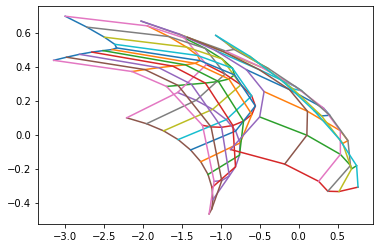

In [43]:
# plot of the full grid

for i in range(n2ha_final.shape[0]): #ionization grid
    plt.plot(P1_SF[i], P2_SF[i], label = 'SF Model')

for j in range(n2ha_final.shape[1]): #metallicity grid
    plt.plot(P1_SF[:,j], P2_SF[:,j], label = 'SF Model')

for m in range(n2ha_final_1d4.shape[0]): #ionization grid
    plt.plot(P1_AGN1d4[m], P2_AGN1d4[m], label = 'AGN -1.4 Model')

for n in range(n2ha_final_1d4.shape[1]): #metallicity grid
    plt.plot(P1_AGN1d4[:,n], P2_AGN1d4[:,n], label = 'AGN -1.4 Model')


## Now let's cut the full grid such that it obeys our P3 limits:

In [44]:
# Extracting indices to keep based on our P3 limits
keep_SF = (( P3_SF > -0.23) & (P3_SF < 0.98))
keep_AGN1d4 = ((P3_AGN1d4 > -0.23) & (P3_AGN1d4 < 0.98))
keep_AGN1d7 = ((P3_AGN1d7 > -0.23) & (P3_AGN1d7 < 0.98))

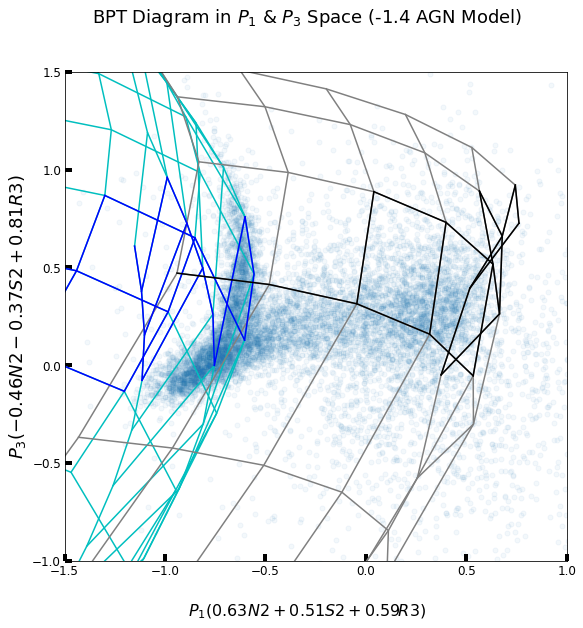

In [69]:
# BPT diagram in P1 and P3 Plane with -1.4 AGN Model
fig, axes = plt.subplots(figsize=(9, 9))
plt.subplots_adjust(wspace=0.)

axes.tick_params(labelsize=12, width=4., length=7., direction='in')
fig.text(0.5, 0.04, '$P_{1}(0.63N2 + 0.51S2 + 0.59R3)$', ha='center', fontsize = 16)
axes.set_ylabel('$P_{3}(-0.46N2 - 0.37S2 + 0.81R3)$', fontsize=18)
fig.suptitle('BPT Diagram in $P_{1}$ & $P_{3}$ Space (-1.4 AGN Model)', fontsize=18 )

# Starforming Model
for i in range(n2ha_final.shape[0]): #ionization
    axes.plot(0.63*n2ha_final[i] + 0.51*s2ha_final[i] + 0.59*o3hb_final[i], -0.46*n2ha_final[i] - 0.37*s2ha_final[i] + 0.81*o3hb_final[i], color='c', lw=1.5)
    
for j in range(n2ha_final.shape[1]): #metallicity
    axes.plot(0.63*n2ha_final[:,j] + 0.51*s2ha_final[:,j] + 0.59*o3hb_final[:,j], -0.46*n2ha_final[:,j] - 0.37*s2ha_final[:,j] + 0.81*o3hb_final[:,j], color='c', lw=1.5)

# AGN (-1.4 Model)
for m in range(n2ha_final_1d4.shape[0]):
    axes.plot(0.63*n2ha_final_1d4[m] + 0.51*s2ha_final_1d4[m] + 0.59*o3hb_final_1d4[m], -0.46*n2ha_final_1d4[m] - 0.37*s2ha_final_1d4[m] + 0.81*o3hb_final_1d4[m], color='gray', lw=1.5)

for n in range(n2ha_final_1d4.shape[1]):
    axes.plot(0.63*n2ha_final_1d4[:,n] + 0.51*s2ha_final_1d4[:,n] + 0.59*o3hb_final_1d4[:,n], -0.46*n2ha_final_1d4[:,n] - 0.37*s2ha_final_1d4[:,n] + 0.81*o3hb_final_1d4[:,n], color='gray', lw=1.5)

# overlay which parts of the model need to be cut    
for a in range(n2ha_final.shape[0]):
    new_keep_SF = keep_SF[a]
    new_P1_SF = P1_SF[a]
    new_P3_SF = P3_SF[a]

    plt.plot(new_P1_SF[new_keep_SF], new_P3_SF[new_keep_SF], color='b', lw=1.5)

for b in range(n2ha_final.shape[1]):
    new_keep_SF = keep_SF[:, b]
    new_P1_SF = P1_SF[:, b]
    new_P3_SF = P3_SF[:, b]

    plt.plot(new_P1_SF[new_keep_SF], new_P3_SF[new_keep_SF], color='b', lw=1.5)
    
for c in range(n2ha_final_1d4.shape[0]):
    new_keep_AGN1d4 = keep_AGN1d4[c]
    new_P1_AGN1d4 = P1_AGN1d4[c]
    new_P3_AGN1d4 = P3_AGN1d4[c]

    plt.plot(new_P1_AGN1d4[new_keep_AGN1d4], new_P3_AGN1d4[new_keep_AGN1d4], color='k', lw=1.5)

for d in range(n2ha_final_1d4.shape[1]):
    new_keep_AGN1d4 = keep_AGN1d4[:, d]
    new_P1_AGN1d4 = P1_AGN1d4[:, d]
    new_P3_AGN1d4 = P3_AGN1d4[:, d]

    plt.plot(new_P1_AGN1d4[new_keep_AGN1d4], new_P3_AGN1d4[new_keep_AGN1d4], color='k', lw=1.5)

# CENTRALFLUX DATA
axes.scatter(0.63*centralflux_data['log_NII_Ha_cf'] + 0.51*centralflux_data['log_SII_Ha_cf'] + 0.59*centralflux_data['log_OIII_Hb_cf'], -0.46*centralflux_data['log_NII_Ha_cf'] - 0.37*centralflux_data['log_SII_Ha_cf'] + 0.81*centralflux_data['log_OIII_Hb_cf'], alpha = 0.05, s = 25)
axes.set_xlim(-1.5, 1.0)
axes.set_ylim(-1.0,1.5)


plt.show()

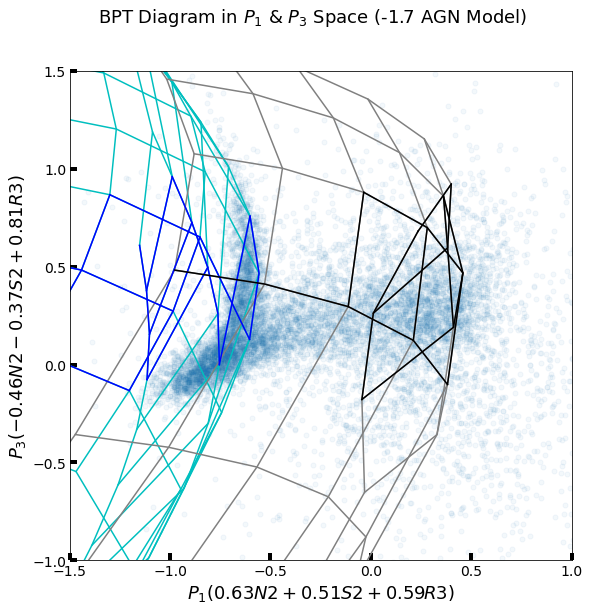

In [65]:
# BPT diagram in P1 and P3 Plane with -1.7 AGN Model
fig, axes = plt.subplots(figsize=(9, 9))
plt.subplots_adjust(wspace=0.)
axes.tick_params(labelsize=14, width=4., length=7., direction='in')

axes.set_xlabel('$P_{1}(0.63N2 + 0.51S2 + 0.59R3)$', fontsize=18)
axes.set_ylabel('$P_{3}(-0.46N2 - 0.37S2 + 0.81R3)$', fontsize=18)
fig.suptitle('BPT Diagram in $P_{1}$ & $P_{3}$ Space (-1.7 AGN Model)', fontsize=18 )

# Starforming Model
for i in range(n2ha_final.shape[0]): #ionization
    axes.plot(0.63*n2ha_final[i] + 0.51*s2ha_final[i] + 0.59*o3hb_final[i], -0.46*n2ha_final[i] - 0.37*s2ha_final[i] + 0.81*o3hb_final[i], color='c', lw=1.5)
    
for j in range(n2ha_final.shape[1]): #metallicity
    axes.plot(0.63*n2ha_final[:,j] + 0.51*s2ha_final[:,j] + 0.59*o3hb_final[:,j], -0.46*n2ha_final[:,j] - 0.37*s2ha_final[:,j] + 0.81*o3hb_final[:,j], color='c', lw=1.5)

# AGN (-1.7 Model)
for k in range(n2ha_final_1d7.shape[0]):
    axes.plot(0.63*n2ha_final_1d7[k] + 0.51*s2ha_final_1d7[k] + 0.59*o3hb_final_1d7[k], -0.46*n2ha_final_1d7[k] - 0.37*s2ha_final_1d7[k] + 0.81*o3hb_final_1d7[k], color='gray', lw=1.5)

for l in range(n2ha_final_1d7.shape[1]):
    axes.plot(0.63*n2ha_final_1d7[:,l] + 0.51*s2ha_final_1d7[:,l] + 0.59*o3hb_final_1d7[:,l], -0.46*n2ha_final_1d7[:,l] - 0.37*s2ha_final_1d7[:,l] + 0.81*o3hb_final_1d7[:,l], color='gray', lw=1.5)

# overlay which parts of the model need to be cut    
for a in range(n2ha_final.shape[0]):
    new_keep_SF = keep_SF[a]
    new_P1_SF = P1_SF[a]
    new_P3_SF = P3_SF[a]

    plt.plot(new_P1_SF[new_keep_SF], new_P3_SF[new_keep_SF], color='b', lw=1.5)

for b in range(n2ha_final.shape[1]):
    new_keep_SF = keep_SF[:, b]
    new_P1_SF = P1_SF[:, b]
    new_P3_SF = P3_SF[:, b]

    plt.plot(new_P1_SF[new_keep_SF], new_P3_SF[new_keep_SF], color='b', lw=1.5)
    
for c in range(n2ha_final_1d7.shape[0]):
    new_keep_AGN1d7 = keep_AGN1d7[c]
    new_P1_AGN1d7 = P1_AGN1d7[c]
    new_P3_AGN1d7 = P3_AGN1d7[c]

    plt.plot(new_P1_AGN1d7[new_keep_AGN1d7], new_P3_AGN1d7[new_keep_AGN1d7], color='k', lw=1.5)

for d in range(n2ha_final_1d7.shape[1]):
    new_keep_AGN1d7 = keep_AGN1d7[:, d]
    new_P1_AGN1d7 = P1_AGN1d7[:, d]
    new_P3_AGN1d7 = P3_AGN1d7[:, d]

    plt.plot(new_P1_AGN1d7[new_keep_AGN1d7], new_P3_AGN1d7[new_keep_AGN1d7], color='k', lw=1.5)

        
# CENTRALFLUX DATA
axes.scatter(0.63*centralflux_data['log_NII_Ha_cf'] + 0.51*centralflux_data['log_SII_Ha_cf'] + 0.59*centralflux_data['log_OIII_Hb_cf'], -0.46*centralflux_data['log_NII_Ha_cf'] - 0.37*centralflux_data['log_SII_Ha_cf'] + 0.81*centralflux_data['log_OIII_Hb_cf'], alpha = 0.05, s = 25)
axes.set_xlim(-1.5, 1.0)
axes.set_ylim(-1.0,1.5)
plt.show()

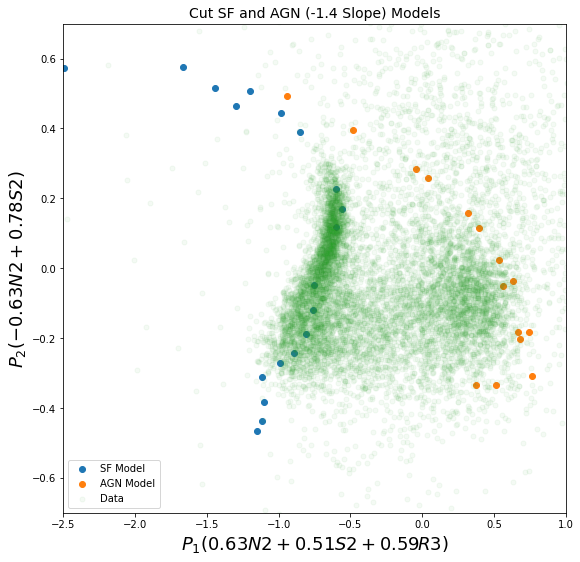

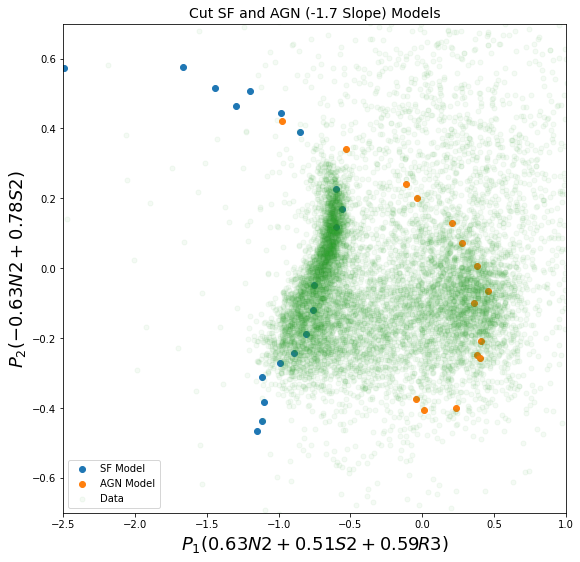

In [45]:
plt.figure(figsize=(9, 9))

plt.scatter(P1_SF[keep_SF], P2_SF[keep_SF], label = 'SF Model')
plt.scatter(P1_AGN1d4[keep_AGN1d4], P2_AGN1d4[keep_AGN1d4], label = 'AGN Model')
plt.scatter(0.63*centralflux_data['log_NII_Ha_cf']+ 0.51*centralflux_data['log_SII_Ha_cf'] + 0.59*centralflux_data['log_OIII_Hb_cf'], -0.63*centralflux_data['log_NII_Ha_cf'] + 0.78*centralflux_data['log_SII_Ha_cf'], alpha = 0.05, s = 25, label = 'Data')

plt.title('Cut SF and AGN (-1.4 Slope) Models', fontsize= 14)
plt.xlabel('$P_{1}(0.63N2 + 0.51S2 + 0.59R3)$', fontsize=18)
plt.ylabel('$P_{2}(-0.63N2 + 0.78 S2)$', fontsize=18)
plt.xlim(-2.5,1.0)
plt.ylim(-0.7,0.7)
plt.legend()
plt.show()

plt.figure(figsize=(9, 9))
           
plt.scatter(P1_SF[keep_SF], P2_SF[keep_SF], label = 'SF Model')
plt.scatter(P1_AGN1d7[keep_AGN1d7], P2_AGN1d7[keep_AGN1d7], label = 'AGN Model')
plt.scatter(0.63*centralflux_data['log_NII_Ha_cf']+ 0.51*centralflux_data['log_SII_Ha_cf'] + 0.59*centralflux_data['log_OIII_Hb_cf'], -0.63*centralflux_data['log_NII_Ha_cf'] + 0.78*centralflux_data['log_SII_Ha_cf'], alpha = 0.05, s = 25, label = 'Data')

plt.title('Cut SF and AGN (-1.7 Slope) Models', fontsize= 14)
plt.xlabel('$P_{1}(0.63N2 + 0.51S2 + 0.59R3)$', fontsize=18)
plt.ylabel('$P_{2}(-0.63N2 + 0.78 S2)$', fontsize=18)
plt.xlim(-2.5,1.0)
plt.ylim(-0.7,0.7)
plt.legend()
plt.show()

In [46]:
def draw_grid(P1_SF, P2_SF, keep_SF, P1_AGN, P2_AGN, keep_AGN, SF_ionization_shape, SF_metallicity_shape, AGN_ionization_shape, AGN_metallicity_shape, power):
    
    plt.figure(figsize=(9, 9))
    
    for i in range(SF_ionization_shape):
        new_keep_SF = keep_SF[:, i]
        new_P1_SF = P1_SF[:, i]
        new_P2_SF = P2_SF[:, i]

        plt.plot(new_P1_SF[new_keep_SF], new_P2_SF[new_keep_SF], color='c', lw=1.5)

    for j in range(SF_metallicity_shape):
        new_keep_SF = keep_SF[j]
        new_P1_SF = P1_SF[j]
        new_P2_SF = P2_SF[j]

        plt.plot(new_P1_SF[new_keep_SF], new_P2_SF[new_keep_SF], color='c', lw=1.5)

    for m in range(AGN_ionization_shape):
        new_keep_AGN = keep_AGN[:, m]
        new_P1_AGN = P1_AGN[:, m]
        new_P2_AGN = P2_AGN[:, m]

        plt.plot(new_P1_AGN[new_keep_AGN], new_P2_AGN[new_keep_AGN], color='k', lw=1.5)

    for n in range(AGN_metallicity_shape):
        new_keep_AGN = keep_AGN[n]
        new_P1_AGN = P1_AGN[n]
        new_P2_AGN = P2_AGN[n]
        
        plt.plot(new_P1_AGN[new_keep_AGN], new_P2_AGN[new_keep_AGN], color='k', lw=1.5)

    plt.scatter(0.63*centralflux_data['log_NII_Ha_cf'] + 0.51*centralflux_data['log_SII_Ha_cf'] + 0.59*centralflux_data['log_OIII_Hb_cf'], -0.63*centralflux_data['log_NII_Ha_cf'] + 0.78*centralflux_data['log_SII_Ha_cf'], alpha = 0.05, s = 25, label = 'Data')

    plt.title('Cut SF and AGN (' + str(power) + ' Slope) Models', fontsize= 14)
    plt.xlabel('$P_{1}(0.63N2 + 0.51S2 + 0.59R3)$', fontsize=18)
    plt.ylabel('$P_{2}(-0.63N2 + 0.78 S2)$', fontsize=18)
    plt.xlim(-2.5,1.0)
    plt.ylim(-0.7,0.7)
    plt.legend()
    plt.show()
    
    return

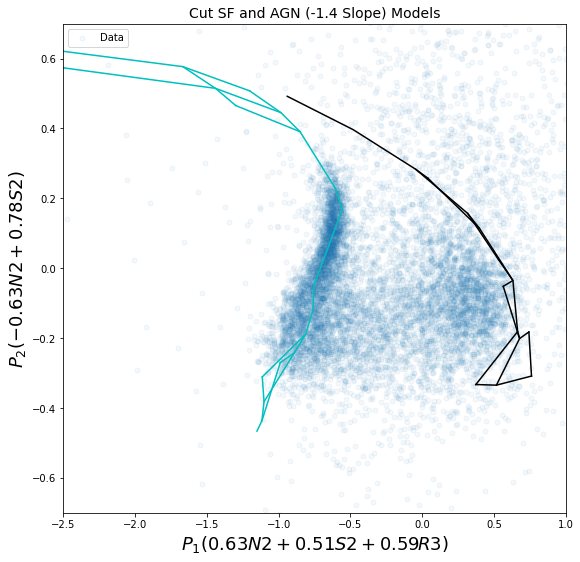

In [47]:
draw_grid(P1_SF, P2_SF, keep_SF, P1_AGN1d4, P2_AGN1d4, keep_AGN1d4, 
          n2ha_final.shape[1], n2ha_final.shape[0], n2ha_final_1d4.shape[1], n2ha_final_1d4.shape[0], -1.4)

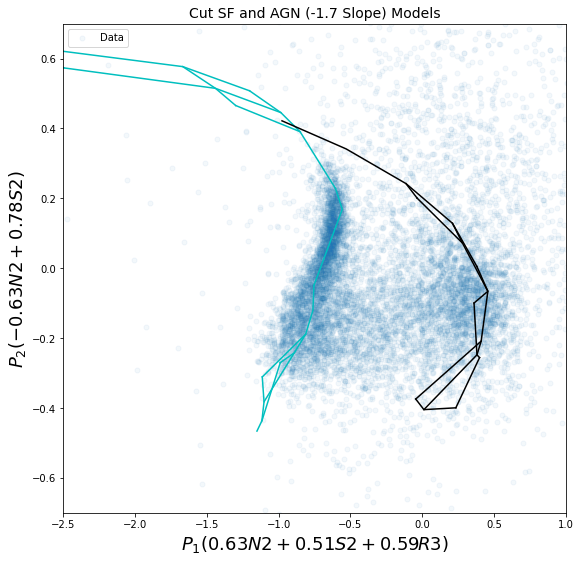

In [48]:
draw_grid(P1_SF, P2_SF, keep_SF, P1_AGN1d7, P2_AGN1d7, keep_AGN1d7, 
          n2ha_final.shape[1], n2ha_final.shape[0], n2ha_final_1d7.shape[1], n2ha_final_1d7.shape[0], -1.7)

# 3D Plots

In [33]:
from mpl_toolkits import mplot3d

## -1.4 AGN Model

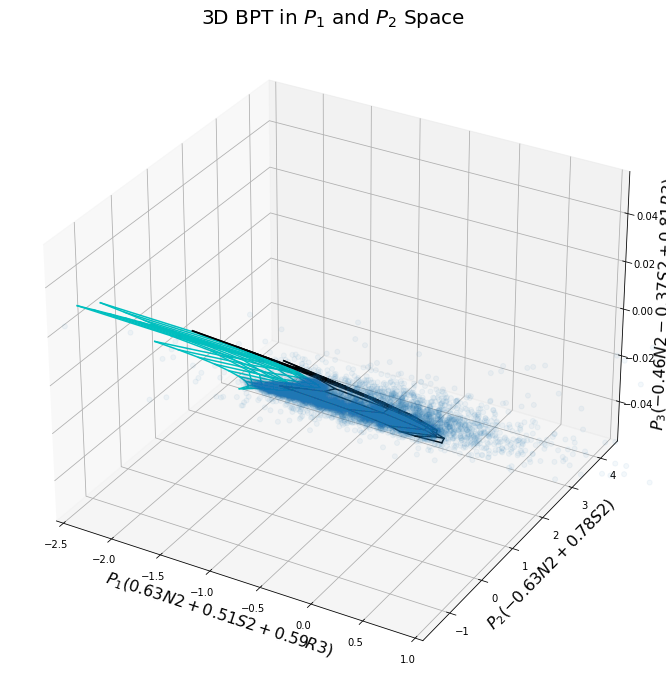

In [54]:
#%matplotlib qt
%matplotlib inline

fig = plt.figure(figsize = (12,12))
ax = plt.axes(projection='3d')

# Starforming Model
for i in range(n2ha_final.shape[0]): #ionization
    ax.plot3D(0.63*n2ha_final[i] + 0.51*s2ha_final[i] + 0.59*o3hb_final[i],-0.63*n2ha_final[i] + 0.78*s2ha_final[i], color='c', lw=1.5)
    
for j in range(n2ha_final.shape[1]): #metallicity
    ax.plot3D(0.63*n2ha_final[:,j] + 0.51*s2ha_final[:,j] + 0.59*o3hb_final[:,j], -0.63*n2ha_final[:,j] + 0.78*s2ha_final[:,j], color='c', lw=1.5)

# AGN (-1.4 Model)
for m in range(n2ha_final_1d4.shape[0]):
    ax.plot3D(0.63*n2ha_final_1d4[m] + 0.51*s2ha_final_1d4[m] + 0.59*o3hb_final_1d4[m],-0.63*n2ha_final_1d4[m] + 0.78*s2ha_final_1d4[m], color='k', lw=1.5)

for n in range(n2ha_final_1d4.shape[1]):
    ax.plot3D(0.63*n2ha_final_1d4[:,n] + 0.51*s2ha_final_1d4[:,n] + 0.59*o3hb_final_1d4[:,n], -0.63*n2ha_final_1d4[:,n] + 0.78*s2ha_final_1d4[:,n], color='k', lw=1.5)

# CENTRALFLUX DATA
ax.scatter3D(0.63*centralflux_data['log_NII_Ha_cf']+ 0.51*centralflux_data['log_SII_Ha_cf'] + 0.59*centralflux_data['log_OIII_Hb_cf'], -0.63*centralflux_data['log_NII_Ha_cf'] + 0.78*centralflux_data['log_SII_Ha_cf'], alpha = 0.05, s = 25)
ax.set_xlim(-2.5,1.0)

ax.set_title('3D BPT in $P_{1}$ and $P_{2}$ Space', fontsize = 20)
ax.set_xlabel('$P_{1}(0.63N2 + 0.51S2 + 0.59R3)$', fontsize = 16)
ax.set_ylabel('$P_{2}(-0.63N2 + 0.78 S2)$', fontsize = 16)
ax.set_zlabel('$P_{3}(-0.46N2 - 0.37S2 + 0.81R3)$', fontsize = 16)

plt.show()

## -1.7 AGN Model

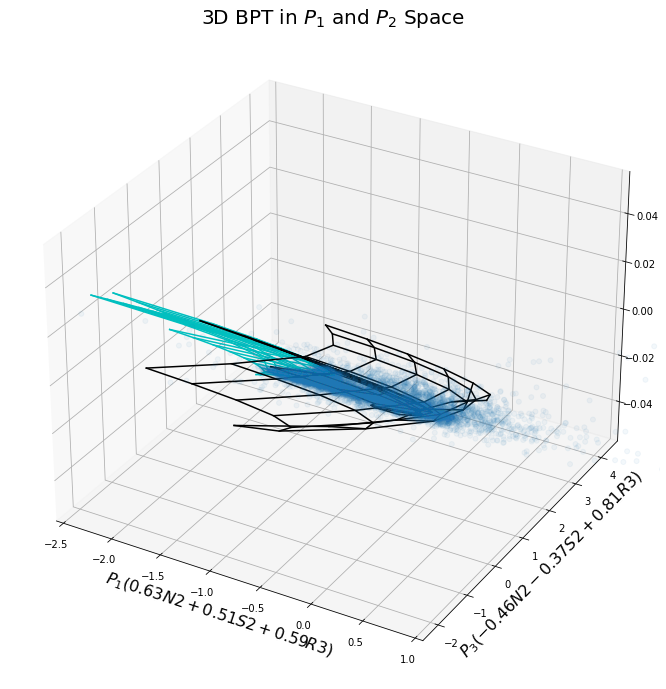

In [50]:
#%matplotlib qt
%matplotlib inline

fig = plt.figure(figsize = (12,12))
ax = plt.axes(projection='3d')

# Starforming Model
for i in range(n2ha_final.shape[0]): #ionization
    ax.plot3D(0.63*n2ha_final[i] + 0.51*s2ha_final[i] + 0.59*o3hb_final[i],-0.63*n2ha_final[i] + 0.78*s2ha_final[i], color='c', lw=1.5)
    
for j in range(n2ha_final.shape[1]): #metallicity
    ax.plot3D(0.63*n2ha_final[:,j] + 0.51*s2ha_final[:,j] + 0.59*o3hb_final[:,j], -0.63*n2ha_final[:,j] + 0.78*s2ha_final[:,j], color='c', lw=1.5)

# AGN (-1.7 Model)
for m in range(n2ha_final_1d7.shape[0]):
    ax.plot3D(0.63*n2ha_final_1d7[m] + 0.51*s2ha_final_1d7[m] + 0.59*o3hb_final_1d7[m],-0.63*n2ha_final_1d7[m] + 0.78*s2ha_final_1d7[m], color='k', lw=1.5)

for n in range(n2ha_final_1d7.shape[1]):
    ax.plot3D(0.63*n2ha_final_1d7[:,n] + 0.51*s2ha_final_1d7[:,n] + 0.59*o3hb_final_1d7[:,n], -0.63*n2ha_final_1d7[:,n] + 0.78*s2ha_final_1d7[:,n], color='k', lw=1.5)

# CENTRALFLUX DATA
ax.scatter3D(0.63*centralflux_data['log_NII_Ha_cf']+ 0.51*centralflux_data['log_SII_Ha_cf'] + 0.59*centralflux_data['log_OIII_Hb_cf'], -0.63*centralflux_data['log_NII_Ha_cf'] + 0.78*centralflux_data['log_SII_Ha_cf'], alpha = 0.05, s = 25)
ax.set_xlim(-2.5,1.0)

ax.set_title('3D BPT in $P_{1}$ and $P_{2}$ Space', fontsize = 20)
ax.set_xlabel('$P_{1}(0.63N2 + 0.51S2 + 0.59R3)$', fontsize = 16)
ax.set_ylabel('$P_{3}(-0.46N2 - 0.37S2 + 0.81R3)$', fontsize= 16)

plt.show()

## 3D BPT in $P_{1}$ and $P_{3}$ Space (-1.4 AGN Model)

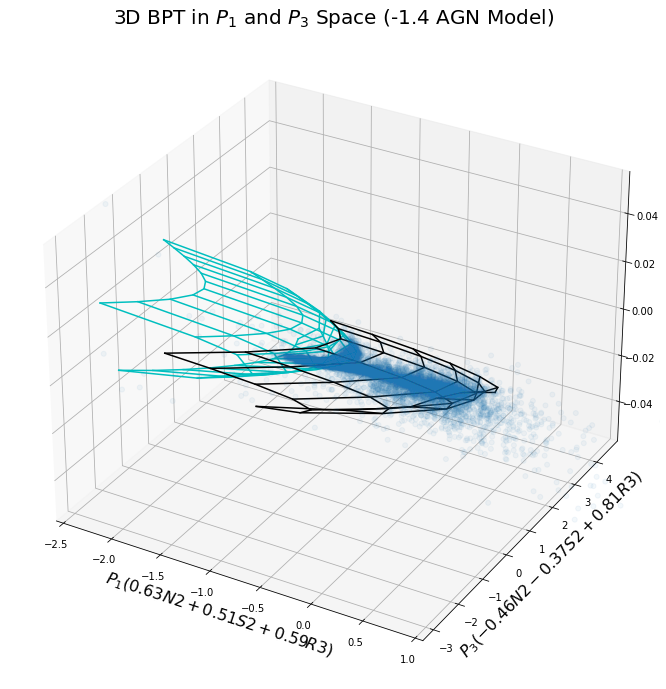

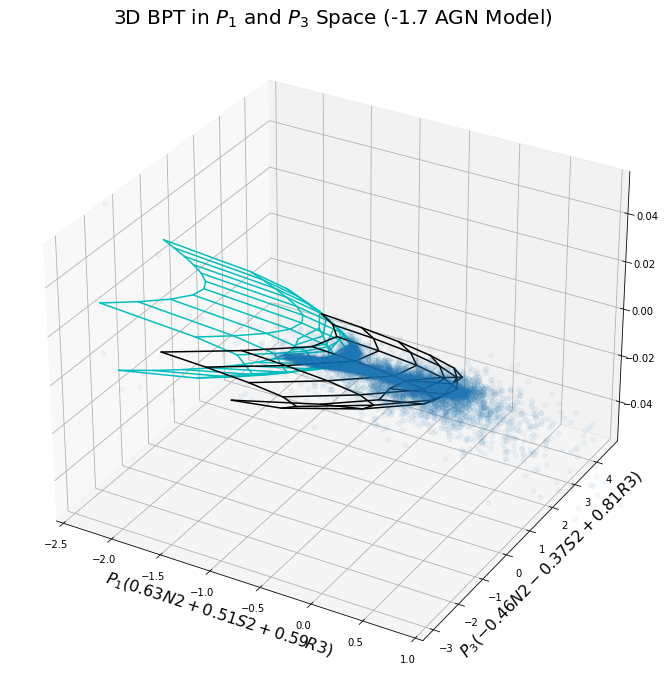

In [36]:
#%matplotlib qt
%matplotlib inline

fig = plt.figure(figsize = (12,12))
ax = plt.axes(projection='3d')

# Starforming Model
for i in range(n2ha_final.shape[0]): #ionization
    ax.plot3D(0.63*n2ha_final[i] + 0.51*s2ha_final[i] + 0.59*o3hb_final[i], -0.46*n2ha_final[i] - 0.37*s2ha_final[i] + 0.81*o3hb_final[i], color='c', lw=1.5)
    
for j in range(n2ha_final.shape[1]): #metallicity
    ax.plot3D(0.63*n2ha_final[:,j] + 0.51*s2ha_final[:,j] + 0.59*o3hb_final[:,j], -0.46*n2ha_final[:,j] - 0.37*s2ha_final[:,j] + 0.81*o3hb_final[:,j], color='c', lw=1.5)

# AGN (-1.4 Model)
for m in range(n2ha_final_1d4.shape[0]):
    ax.plot3D(0.63*n2ha_final_1d4[m] + 0.51*s2ha_final_1d4[m] + 0.59*o3hb_final_1d4[m], -0.46*n2ha_final_1d4[m] - 0.37*s2ha_final_1d4[m] + 0.81*o3hb_final_1d4[m], color='k', lw=1.5)

for n in range(n2ha_final_1d4.shape[1]):
    ax.plot3D(0.63*n2ha_final_1d4[:,n] + 0.51*s2ha_final_1d4[:,n] + 0.59*o3hb_final_1d4[:,n], -0.46*n2ha_final_1d4[:,n] - 0.37*s2ha_final_1d4[:,n] + 0.81*o3hb_final_1d4[:,n], color='k', lw=1.5)

    
# CENTRALFLUX DATA
ax.scatter3D(0.63*centralflux_data['log_NII_Ha_cf'] + 0.51*centralflux_data['log_SII_Ha_cf'] + 0.59*centralflux_data['log_OIII_Hb_cf'], -0.46*centralflux_data['log_NII_Ha_cf'] - 0.37*centralflux_data['log_SII_Ha_cf'] + 0.81*centralflux_data['log_OIII_Hb_cf'], alpha = 0.05, s = 25)
ax.set_xlim(-2.5,1.0)

ax.set_title('3D BPT in $P_{1}$ and $P_{3}$ Space (-1.4 AGN Model)', fontsize = 20)
ax.set_xlabel('$P_{1}(0.63N2 + 0.51S2 + 0.59R3)$', fontsize = 16)
ax.set_ylabel('$P_{3}(-0.46N2 - 0.37S2 + 0.81R3)$', fontsize = 16)

fig = plt.figure(figsize = (12,12))
ax = plt.axes(projection='3d')

# Starforming Model
for i in range(n2ha_final.shape[0]): #ionization
    ax.plot3D(0.63*n2ha_final[i] + 0.51*s2ha_final[i] + 0.59*o3hb_final[i], -0.46*n2ha_final[i] - 0.37*s2ha_final[i] + 0.81*o3hb_final[i], color='c', lw=1.5)
    
for j in range(n2ha_final.shape[1]): #metallicity
    ax.plot3D(0.63*n2ha_final[:,j] + 0.51*s2ha_final[:,j] + 0.59*o3hb_final[:,j], -0.46*n2ha_final[:,j] - 0.37*s2ha_final[:,j] + 0.81*o3hb_final[:,j], color='c', lw=1.5)

# AGN (-1.7 Model)
for k in range(n2ha_final_1d7.shape[0]):
    ax.plot3D(0.63*n2ha_final_1d7[k] + 0.51*s2ha_final_1d7[k] + 0.59*o3hb_final_1d7[k], -0.46*n2ha_final_1d7[k] - 0.37*s2ha_final_1d7[k] + 0.81*o3hb_final_1d7[k], color='k', lw=1.5)

for l in range(n2ha_final_1d7.shape[1]):
    ax.plot3D(0.63*n2ha_final_1d7[:,l] + 0.51*s2ha_final_1d7[:,l] + 0.59*o3hb_final_1d7[:,l], -0.46*n2ha_final_1d7[:,l] - 0.37*s2ha_final_1d7[:,l] + 0.81*o3hb_final_1d7[:,l], color='k', lw=1.5)
    
# CENTRALFLUX DATA
ax.scatter3D(0.63*centralflux_data['log_NII_Ha_cf'] + 0.51*centralflux_data['log_SII_Ha_cf'] + 0.59*centralflux_data['log_OIII_Hb_cf'], -0.46*centralflux_data['log_NII_Ha_cf'] - 0.37*centralflux_data['log_SII_Ha_cf'] + 0.81*centralflux_data['log_OIII_Hb_cf'], alpha = 0.05, s = 25)
ax.set_xlim(-2.5,1.0)

ax.set_title('3D BPT in $P_{1}$ and $P_{3}$ Space (-1.7 AGN Model)', fontsize = 20)
ax.set_xlabel('$P_{1}(0.63N2 + 0.51S2 + 0.59R3)$', fontsize = 16)
ax.set_ylabel('$P_{3}(-0.46N2 - 0.37S2 + 0.81R3)$', fontsize= 16)

plt.show()